In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import optuna
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from torchvision import models, datasets, transforms

/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json

# Function to load configurations
def load_config(config_file):
    with open(config_file, 'r') as file:
        config = json.load(file)
    return config

# Load the configuration
config = load_config('config/config.json')

# Access the dataset path
dataset_dir = config['dataset_path']
train_dir = config['train_path']
val_dir = config['val_path']
test_dir = config['test_path']

In [3]:
number_of_epochs = 30

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Data loaders
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

val_data = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [6]:
# Initialize a dictionary to store metrics
history = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

In [7]:
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    momentum = trial.suggest_uniform('momentum', 0.7, 0.99)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    
    # Update DataLoader batch size
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    # Initialize the model
    model = models.resnet50(pretrained=True)
    num_classes = len(train_data.classes)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    num_epochs = 5
    best_val_accuracy = 0

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = correct_train / total_train
        train_loss /= len(train_loader)
        history['train_accuracy'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_labels = []
        val_predictions = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val += labels.size(0)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                val_labels.extend(labels.cpu().numpy())
                val_predictions.extend(predicted.cpu().numpy())
        
        val_accuracy = accuracy_score(val_labels, val_predictions)
        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        best_val_accuracy = max(best_val_accuracy, val_accuracy)
    
    return best_val_accuracy

In [8]:
# Run Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-12-08 08:50:34,874] A new study created in memory with name: no-name-c5511c72-71de-4039-85a3-e2cc974440ef
/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.7, 0.99)
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead

Epoch 1/5 - Train Loss: 0.7188, Train Accuracy: 0.6237, Val Loss: 0.7777, Val Accuracy: 0.6071
Epoch 2/5 - Train Loss: 0.6538, Train Accuracy: 0.5979, Val Loss: 0.6581, Val Accuracy: 0.6429
Epoch 3/5 - Train Loss: 0.6441, Train Accuracy: 0.5876, Val Loss: 0.6685, Val Accuracy: 0.6429
Epoch 4/5 - Train Loss: 0.5770, Train Accuracy: 0.6804, Val Loss: 0.6860, Val Accuracy: 0.5714


[I 2024-12-08 08:51:40,864] Trial 0 finished with value: 0.6428571428571429 and parameters: {'lr': 0.0003585610665133372, 'momentum': 0.8674212405129209, 'batch_size': 64}. Best is trial 0 with value: 0.6428571428571429.


Epoch 5/5 - Train Loss: 0.5378, Train Accuracy: 0.8557, Val Loss: 0.7284, Val Accuracy: 0.5000


/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.7, 0.99)
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: 

Epoch 1/5 - Train Loss: 0.7631, Train Accuracy: 0.4845, Val Loss: 0.7154, Val Accuracy: 0.6071
Epoch 2/5 - Train Loss: 0.6993, Train Accuracy: 0.5722, Val Loss: 0.6867, Val Accuracy: 0.6786
Epoch 3/5 - Train Loss: 0.5529, Train Accuracy: 0.7990, Val Loss: 0.8177, Val Accuracy: 0.4643
Epoch 4/5 - Train Loss: 0.5783, Train Accuracy: 0.7268, Val Loss: 0.8598, Val Accuracy: 0.5000


[I 2024-12-08 08:52:46,756] Trial 1 finished with value: 0.6785714285714286 and parameters: {'lr': 0.0007780286724983357, 'momentum': 0.8427828920205602, 'batch_size': 64}. Best is trial 1 with value: 0.6785714285714286.


Epoch 5/5 - Train Loss: 0.4582, Train Accuracy: 0.8196, Val Loss: 0.7861, Val Accuracy: 0.5000


/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.7, 0.99)
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: 

Epoch 1/5 - Train Loss: 0.8542, Train Accuracy: 0.4227, Val Loss: 0.7133, Val Accuracy: 0.4286
Epoch 2/5 - Train Loss: 0.6440, Train Accuracy: 0.6186, Val Loss: 0.7717, Val Accuracy: 0.4643
Epoch 3/5 - Train Loss: 0.6182, Train Accuracy: 0.6340, Val Loss: 0.8085, Val Accuracy: 0.3929
Epoch 4/5 - Train Loss: 0.5944, Train Accuracy: 0.6495, Val Loss: 0.8327, Val Accuracy: 0.3571


[I 2024-12-08 08:53:55,965] Trial 2 finished with value: 0.4642857142857143 and parameters: {'lr': 0.00019475046281964157, 'momentum': 0.7562900287462871, 'batch_size': 32}. Best is trial 1 with value: 0.6785714285714286.


Epoch 5/5 - Train Loss: 0.5981, Train Accuracy: 0.7268, Val Loss: 0.8084, Val Accuracy: 0.3929


/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.7, 0.99)
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: 

Epoch 1/5 - Train Loss: 0.7375, Train Accuracy: 0.5155, Val Loss: 0.8052, Val Accuracy: 0.3571
Epoch 2/5 - Train Loss: 0.6034, Train Accuracy: 0.6289, Val Loss: 0.8770, Val Accuracy: 0.5357
Epoch 3/5 - Train Loss: 0.5384, Train Accuracy: 0.7629, Val Loss: 0.8761, Val Accuracy: 0.5000
Epoch 4/5 - Train Loss: 0.4736, Train Accuracy: 0.8402, Val Loss: 0.7971, Val Accuracy: 0.6071


[I 2024-12-08 08:55:19,489] Trial 3 finished with value: 0.6071428571428571 and parameters: {'lr': 0.0003488815161577948, 'momentum': 0.8335038144730876, 'batch_size': 16}. Best is trial 1 with value: 0.6785714285714286.


Epoch 5/5 - Train Loss: 0.4183, Train Accuracy: 0.8402, Val Loss: 0.9255, Val Accuracy: 0.6071


/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.7, 0.99)
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: 

Epoch 1/5 - Train Loss: 0.7566, Train Accuracy: 0.5361, Val Loss: 0.7171, Val Accuracy: 0.6429
Epoch 2/5 - Train Loss: 0.6908, Train Accuracy: 0.6959, Val Loss: 2.2219, Val Accuracy: 0.3929
Epoch 3/5 - Train Loss: 1.1453, Train Accuracy: 0.7371, Val Loss: 3.6489, Val Accuracy: 0.4286
Epoch 4/5 - Train Loss: 2.0051, Train Accuracy: 0.7371, Val Loss: 22.1944, Val Accuracy: 0.5714


[I 2024-12-08 08:56:29,788] Trial 4 finished with value: 0.6428571428571429 and parameters: {'lr': 0.00734962156492429, 'momentum': 0.9515178301689946, 'batch_size': 32}. Best is trial 1 with value: 0.6785714285714286.


Epoch 5/5 - Train Loss: 2.8134, Train Accuracy: 0.6649, Val Loss: 37.2094, Val Accuracy: 0.5714


/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.7, 0.99)
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: 

Epoch 1/5 - Train Loss: 0.7046, Train Accuracy: 0.5928, Val Loss: 0.7059, Val Accuracy: 0.4643
Epoch 2/5 - Train Loss: 0.6582, Train Accuracy: 0.6598, Val Loss: 0.6556, Val Accuracy: 0.6071
Epoch 3/5 - Train Loss: 0.6048, Train Accuracy: 0.7680, Val Loss: 0.6704, Val Accuracy: 0.5357
Epoch 4/5 - Train Loss: 0.4530, Train Accuracy: 0.8247, Val Loss: 0.6770, Val Accuracy: 0.6429


[I 2024-12-08 08:57:33,674] Trial 5 finished with value: 0.6428571428571429 and parameters: {'lr': 0.0006735350024201861, 'momentum': 0.9328752626311168, 'batch_size': 64}. Best is trial 1 with value: 0.6785714285714286.


Epoch 5/5 - Train Loss: 0.4541, Train Accuracy: 0.8660, Val Loss: 0.8589, Val Accuracy: 0.5357


/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.7, 0.99)
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: 

Epoch 1/5 - Train Loss: 0.7502, Train Accuracy: 0.4639, Val Loss: 0.7008, Val Accuracy: 0.4643
Epoch 2/5 - Train Loss: 0.7181, Train Accuracy: 0.4742, Val Loss: 0.6865, Val Accuracy: 0.5000
Epoch 3/5 - Train Loss: 0.6198, Train Accuracy: 0.5464, Val Loss: 0.6923, Val Accuracy: 0.5357
Epoch 4/5 - Train Loss: 0.6249, Train Accuracy: 0.5825, Val Loss: 0.7135, Val Accuracy: 0.5357


[I 2024-12-08 08:58:36,905] Trial 6 finished with value: 0.5357142857142857 and parameters: {'lr': 3.3963138968603606e-05, 'momentum': 0.8439317736254367, 'batch_size': 64}. Best is trial 1 with value: 0.6785714285714286.


Epoch 5/5 - Train Loss: 0.6590, Train Accuracy: 0.5722, Val Loss: 0.7397, Val Accuracy: 0.4643


/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.7, 0.99)
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: 

Epoch 1/5 - Train Loss: 0.7197, Train Accuracy: 0.5464, Val Loss: 0.6233, Val Accuracy: 0.6786
Epoch 2/5 - Train Loss: 0.4886, Train Accuracy: 0.7732, Val Loss: 0.8503, Val Accuracy: 0.6429
Epoch 3/5 - Train Loss: 0.3216, Train Accuracy: 0.8711, Val Loss: 0.5036, Val Accuracy: 0.7143
Epoch 4/5 - Train Loss: 0.1645, Train Accuracy: 0.9639, Val Loss: 0.6643, Val Accuracy: 0.7857


[I 2024-12-08 08:59:53,396] Trial 7 finished with value: 0.7857142857142857 and parameters: {'lr': 0.000919715216562164, 'momentum': 0.9406432273114094, 'batch_size': 16}. Best is trial 7 with value: 0.7857142857142857.


Epoch 5/5 - Train Loss: 0.1988, Train Accuracy: 0.9381, Val Loss: 0.5332, Val Accuracy: 0.7500


/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.7, 0.99)
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: 

Epoch 1/5 - Train Loss: 0.6888, Train Accuracy: 0.5103, Val Loss: 0.7321, Val Accuracy: 0.5000
Epoch 2/5 - Train Loss: 0.7036, Train Accuracy: 0.5103, Val Loss: 0.7275, Val Accuracy: 0.5357
Epoch 3/5 - Train Loss: 0.6830, Train Accuracy: 0.5567, Val Loss: 0.6958, Val Accuracy: 0.5357
Epoch 4/5 - Train Loss: 0.6813, Train Accuracy: 0.5361, Val Loss: 0.6888, Val Accuracy: 0.5714


[I 2024-12-08 09:00:56,661] Trial 8 finished with value: 0.5714285714285714 and parameters: {'lr': 1.4948969215203812e-05, 'momentum': 0.7387202616743902, 'batch_size': 64}. Best is trial 7 with value: 0.7857142857142857.


Epoch 5/5 - Train Loss: 0.6756, Train Accuracy: 0.5722, Val Loss: 0.6985, Val Accuracy: 0.5357


/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/var/folders/_0/n_t3__qd6k15bv63l5bktb8m0000gn/T/ipykernel_68367/3780013472.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform('momentum', 0.7, 0.99)
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: 

Epoch 1/5 - Train Loss: 0.7211, Train Accuracy: 0.5567, Val Loss: 0.6423, Val Accuracy: 0.6429
Epoch 2/5 - Train Loss: 0.5558, Train Accuracy: 0.7474, Val Loss: 0.9643, Val Accuracy: 0.4286
Epoch 3/5 - Train Loss: 0.4646, Train Accuracy: 0.7887, Val Loss: 0.9665, Val Accuracy: 0.4286
Epoch 4/5 - Train Loss: 0.3387, Train Accuracy: 0.8608, Val Loss: 0.7278, Val Accuracy: 0.5714


[I 2024-12-08 09:02:14,140] Trial 9 finished with value: 0.6428571428571429 and parameters: {'lr': 0.0009454332523024557, 'momentum': 0.7260779214883074, 'batch_size': 16}. Best is trial 7 with value: 0.7857142857142857.


Epoch 5/5 - Train Loss: 0.2996, Train Accuracy: 0.9485, Val Loss: 0.7310, Val Accuracy: 0.6071


In [9]:
# Best hyperparameters
best_hyperparams = study.best_params
print(f"Best Hyperparameters: {best_hyperparams}")

Best Hyperparameters: {'lr': 0.000919715216562164, 'momentum': 0.9406432273114094, 'batch_size': 16}


In [10]:
# Final model training with best hyperparameters
best_model = models.resnet50(pretrained=True)
best_model.fc = nn.Linear(best_model.fc.in_features, len(train_data.classes))
best_model.to(device)

/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis_test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    best_model.parameters(),
    lr=best_hyperparams['lr'],
    momentum=best_hyperparams['momentum']
)
batch_size = best_hyperparams['batch_size']

In [12]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [13]:

for epoch in range(number_of_epochs):
    best_model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = best_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate on validation set after each epoch
    best_model.eval()
    val_labels = []
    val_predictions = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = best_model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())

    epoch_accuracy = accuracy_score(val_labels, val_predictions)
    history['val_accuracy'].append(epoch_accuracy)
    print(f"Epoch {epoch+1}/{number_of_epochs} - Validation Accuracy: {epoch_accuracy:.4f}")


Epoch 1/30 - Validation Accuracy: 0.6429
Epoch 2/30 - Validation Accuracy: 0.4286
Epoch 3/30 - Validation Accuracy: 0.3929
Epoch 4/30 - Validation Accuracy: 0.4286
Epoch 5/30 - Validation Accuracy: 0.7500
Epoch 6/30 - Validation Accuracy: 0.5357
Epoch 7/30 - Validation Accuracy: 0.5357
Epoch 8/30 - Validation Accuracy: 0.6786
Epoch 9/30 - Validation Accuracy: 0.5357
Epoch 10/30 - Validation Accuracy: 0.5357
Epoch 11/30 - Validation Accuracy: 0.6071
Epoch 12/30 - Validation Accuracy: 0.7143
Epoch 13/30 - Validation Accuracy: 0.7143
Epoch 14/30 - Validation Accuracy: 0.7500
Epoch 15/30 - Validation Accuracy: 0.7143
Epoch 16/30 - Validation Accuracy: 0.6071
Epoch 17/30 - Validation Accuracy: 0.7857
Epoch 18/30 - Validation Accuracy: 0.6071
Epoch 19/30 - Validation Accuracy: 0.6429
Epoch 20/30 - Validation Accuracy: 0.6071
Epoch 21/30 - Validation Accuracy: 0.6429
Epoch 22/30 - Validation Accuracy: 0.7500
Epoch 23/30 - Validation Accuracy: 0.7500
Epoch 24/30 - Validation Accuracy: 0.7500
E

In [14]:
file_name = f'Pth_Files/Resnet50_model_Hyperparmeter_{number_of_epochs}.keras'

In [15]:
torch.save(best_model.state_dict(), 'best_resnet50_model.pth')

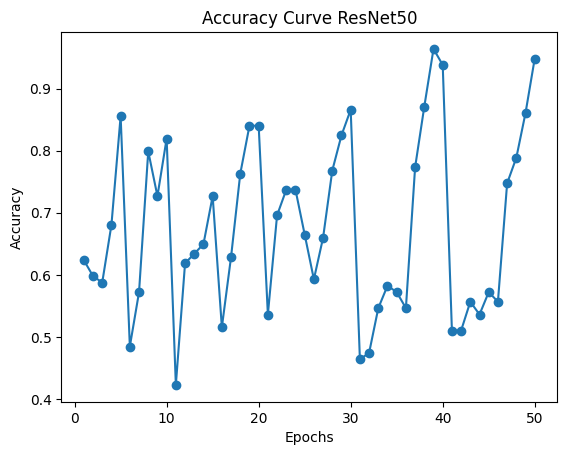

In [16]:
acc = history['train_accuracy']
plt.plot(range(1, len(acc) + 1), acc, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve ResNet50')
plt.show()

In [17]:
def evaluate_model(model):
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    classes = train_data.classes

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    if len(all_labels) == 0:
        print("No data was loaded. Check your dataset and DataLoader.")
    else:
        # Calculate and print the confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)
        # Plotting the confusion matrix
        plt.figure(figsize=(10,7))
        sns.heatmap(
            cm,
            annot=True,
            fmt='g',
            cmap='Blues',
            xticklabels=classes,
            yticklabels=classes
        )
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.title('Confusion Matrix Resnet50')
        plt.show()

        # Calculate accuracy
        accuracy = accuracy_score(all_labels, all_predictions)
        print(f'Validation Accuracy: {accuracy * 100:.2f}%')
        
        print('\n--------------------------------\n')
        print("Classification Report Resnet50:")
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        # Create a DataFrame to display the results in tabular format
        metrics_df = pd.DataFrame({
            'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
            'Score': [accuracy, precision, recall, f1]
        })

        # Display the DataFrame
        print(metrics_df.to_string(index=False))

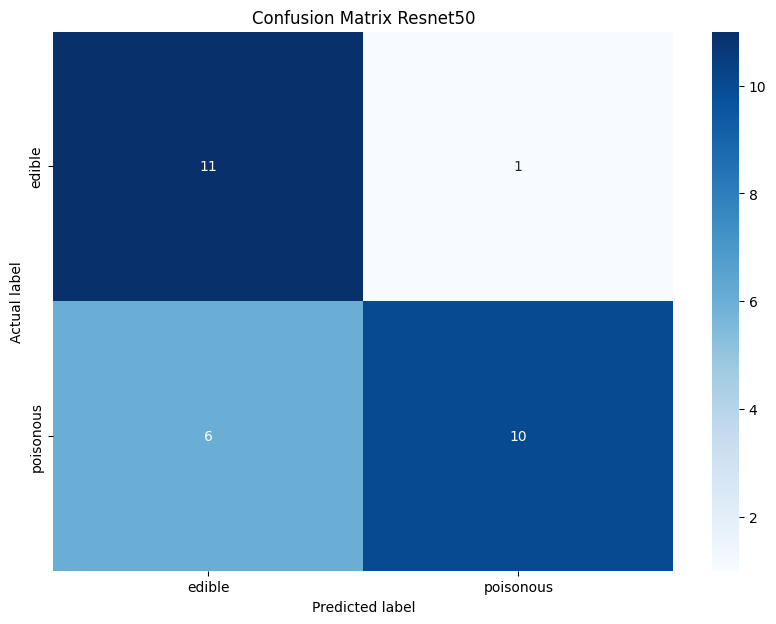

Validation Accuracy: 75.00%

--------------------------------

Classification Report Resnet50:
   Metric    Score
 Accuracy 0.750000
Precision 0.796791
   Recall 0.750000
 F1 Score 0.748404


In [18]:
evaluate_model(best_model)